In [2]:
pip install numpy pandas yfinance scikit-learn matplotlib


Note: you may need to restart the kernel to use updated packages.


In [3]:
import numpy as np
import pandas as pd
import yfinance as yf
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


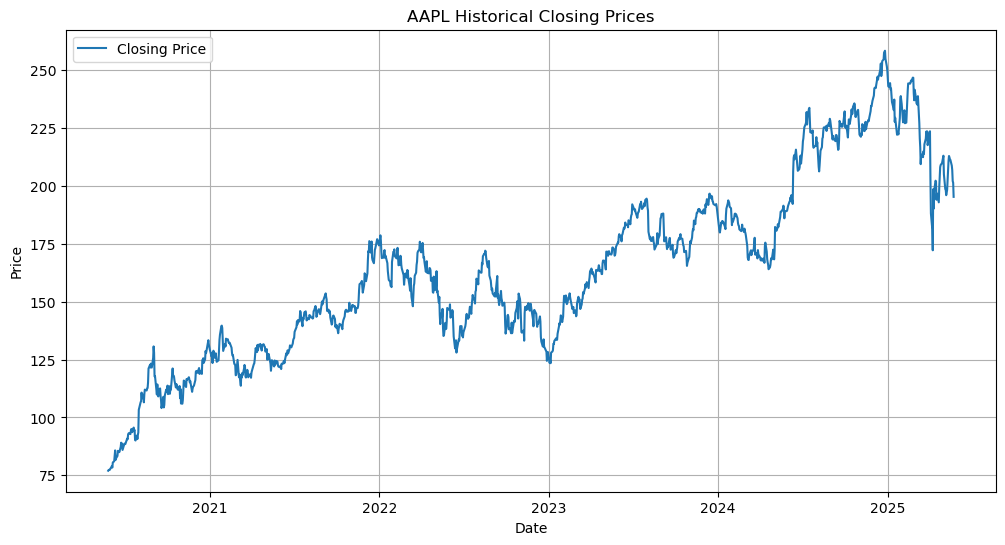

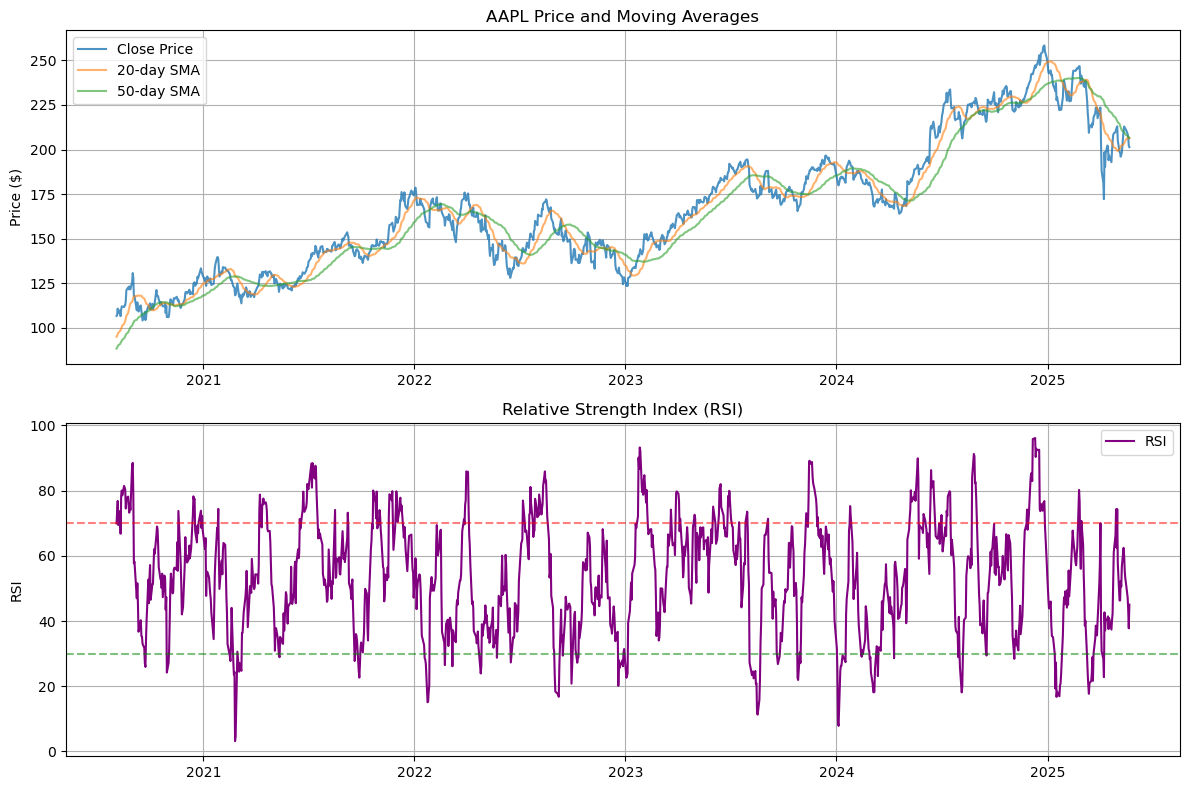

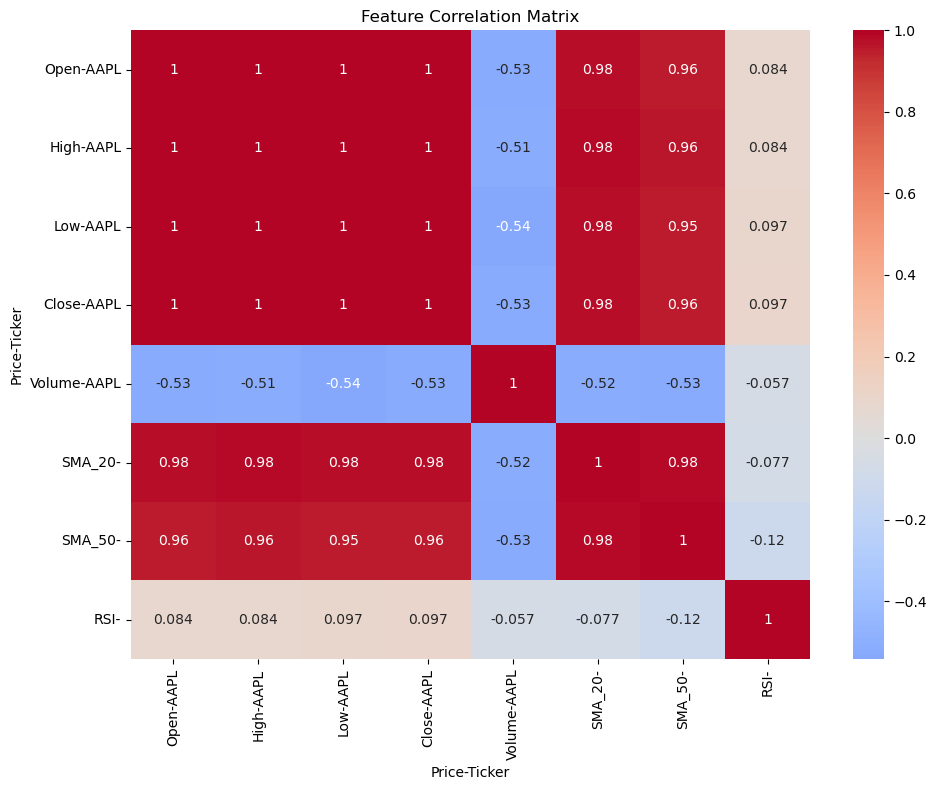


Model Performance Metrics for AAPL:
Mean Squared Error: 10.69
R-squared Score: 0.99


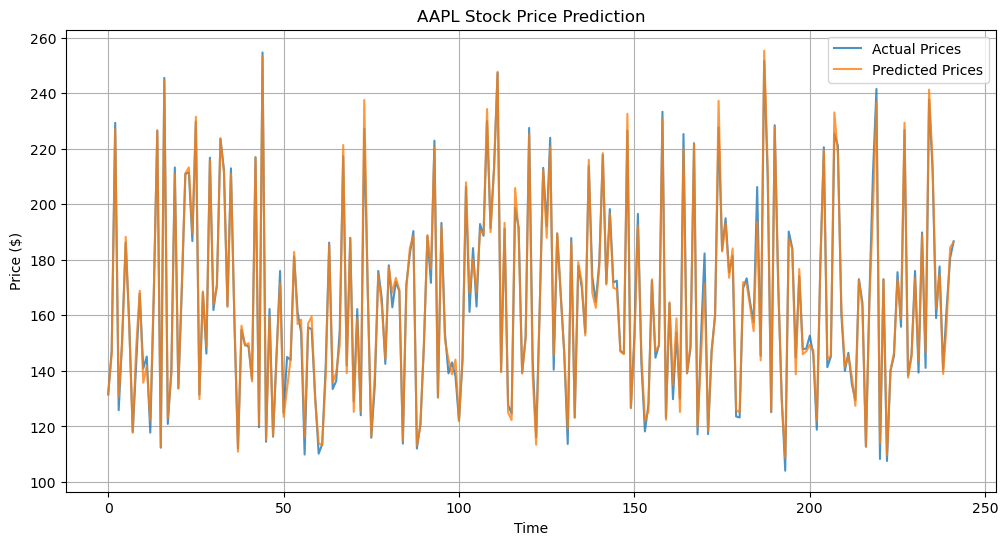

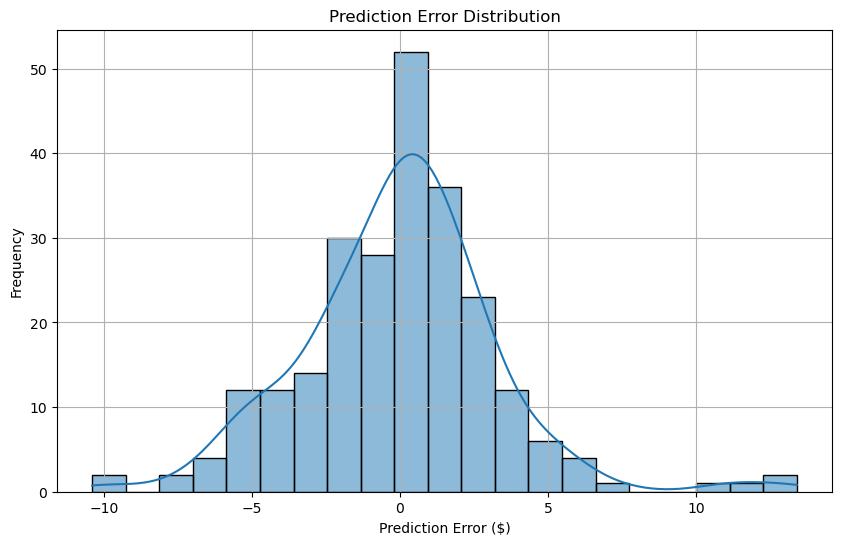


Predicted next day's closing price for AAPL: $196.36


In [4]:
class StockPredictor:
    def __init__(self, symbol, prediction_days=30):
        self.symbol = symbol
        self.prediction_days = prediction_days
        self.model = RandomForestRegressor(n_estimators=100, random_state=42)
        
    def fetch_stock_data(self, years=5):
        """Fetch stock data for the specified symbol"""
        end_date = datetime.now()
        start_date = end_date - timedelta(days=years*365)
        
        try:
            df = yf.download(self.symbol, start=start_date, end=end_date)
            if df.empty:
                raise ValueError(f"No data found for symbol {self.symbol}")
            return df
        except Exception as e:
            print(f"Error fetching data: {e}")
            return None

    def plot_stock_history(self, df):
        """Plot historical stock data with volume"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), gridspec_kw={'height_ratios': [3, 1]})
        
        # Plot stock prices
        ax1.plot(df.index, df['Close'], label='Close Price')
        ax1.set_title(f'{self.symbol} Stock Price History')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot volume
        ax2.bar(df.index, df['Volume'], color='gray', alpha=0.5)
        ax2.set_title('Trading Volume')
        ax2.set_ylabel('Volume')
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()

    def plot_technical_indicators(self, df):
        """Plot technical indicators (SMA and RSI)"""
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))
        
        # Plot price and SMAs
        ax1.plot(df.index, df['Close'], label='Close Price', alpha=0.8)
        ax1.plot(df.index, df['SMA_20'], label='20-day SMA', alpha=0.6)
        ax1.plot(df.index, df['SMA_50'], label='50-day SMA', alpha=0.6)
        ax1.set_title(f'{self.symbol} Price and Moving Averages')
        ax1.set_ylabel('Price ($)')
        ax1.legend()
        ax1.grid(True)
        
        # Plot RSI
        ax2.plot(df.index, df['RSI'], label='RSI', color='purple')
        ax2.axhline(y=70, color='r', linestyle='--', alpha=0.5)
        ax2.axhline(y=30, color='g', linestyle='--', alpha=0.5)
        ax2.set_title('Relative Strength Index (RSI)')
        ax2.set_ylabel('RSI')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        plt.show()
          
    def plot_stock_history(self, df):  # <-- Insert this method here
        """Plot historical closing prices"""
        plt.figure(figsize=(12, 6))
        plt.plot(df['Close'], label='Closing Price')
        plt.title(f'{self.symbol} Historical Closing Prices')
        plt.xlabel('Date')
        plt.ylabel('Price')
        plt.legend()
        plt.grid(True)
        plt.show()

    def prepare_data(self, df):
        """Prepare data for training"""
        # Create features from technical indicators
        df['SMA_20'] = df['Close'].rolling(window=20).mean()
        df['SMA_50'] = df['Close'].rolling(window=50).mean()
        df['RSI'] = self.calculate_rsi(df['Close'])
        
        # Create target variable (next day's closing price)
        df['Target'] = df['Close'].shift(-1)
        
        # Drop NaN values
        df.dropna(inplace=True)
        
        # Select features
        features = ['Open', 'High', 'Low', 'Close', 'Volume', 'SMA_20', 'SMA_50', 'RSI']
        X = df[features]
        y = df['Target']
        
        return X, y, df

    def plot_correlation_matrix(self, X):
        """Plot correlation matrix of features"""
        plt.figure(figsize=(10, 8))
        correlation_matrix = X.corr()
        sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
        plt.title('Feature Correlation Matrix')
        plt.tight_layout()
        plt.show()

    def calculate_rsi(self, prices, period=14):
        """Calculate RSI technical indicator"""
        delta = prices.diff()
        gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
        loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()
        
        rs = gain / loss
        rsi = 100 - (100 / (1 + rs))
        return rsi
    
    def train_model(self, X, y):
        """Train the prediction model"""
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
        
        self.model.fit(X_train, y_train)
        
        # Make predictions on test set
        predictions = self.model.predict(X_test)
        
        # Calculate metrics
        mse = mean_squared_error(y_test, predictions)
        r2 = r2_score(y_test, predictions)
        
        return X_test, y_test, predictions, mse, r2
    
    def plot_predictions(self, X_test, y_test, predictions):
        """Plot actual vs predicted prices"""
        plt.figure(figsize=(12, 6))
        plt.plot(y_test.values, label='Actual Prices', alpha=0.8)
        plt.plot(predictions, label='Predicted Prices', alpha=0.8)
        plt.title(f'{self.symbol} Stock Price Prediction')
        plt.xlabel('Time')
        plt.ylabel('Price ($)')
        plt.legend()
        plt.grid(True)
        plt.show()

        # Plot prediction error distribution
        plt.figure(figsize=(10, 6))
        errors = y_test.values - predictions
        sns.histplot(errors, kde=True)
        plt.title('Prediction Error Distribution')
        plt.xlabel('Prediction Error ($)')
        plt.ylabel('Frequency')
        plt.grid(True)
        plt.show()
    
    def predict_future(self, last_data):
        """Predict future prices"""
        future_predictions = self.model.predict(last_data)
        return future_predictions

def main():
    # Example usage
    symbol = 'AAPL'  # Example with Apple stock
    predictor = StockPredictor(symbol)
    
    # Fetch data
    df = predictor.fetch_stock_data()
    if df is None:
        return
    
    # Plot historical data
    predictor.plot_stock_history(df)
    
    # Prepare data and train model
    X, y, df_with_indicators = predictor.prepare_data(df)
    
    # Plot technical indicators
    predictor.plot_technical_indicators(df_with_indicators)
    
    # Plot correlation matrix
    predictor.plot_correlation_matrix(X)
    
    # Train model and get predictions
    X_test, y_test, predictions, mse, r2 = predictor.train_model(X, y)
    
    # Print metrics
    print(f"\nModel Performance Metrics for {symbol}:")
    print(f"Mean Squared Error: {mse:.2f}")
    print(f"R-squared Score: {r2:.2f}")
    
    # Plot predictions and error distribution
    predictor.plot_predictions(X_test, y_test, predictions)
    
    # Predict next day's price
    last_data = X.iloc[-1:].values
    next_day_prediction = predictor.predict_future(last_data)
    print(f"\nPredicted next day's closing price for {symbol}: ${next_day_prediction[0]:.2f}")

if __name__ == "__main__":
    main()